# Sepsis Cases Project


In [56]:
import pm4py
import pandas as pd
from pm4py.algo.evaluation.generalization import algorithm as generalization_evaluator
from pm4py.algo.evaluation.simplicity import algorithm as simplicity_evaluator
from pm4py.algo.analysis.woflan import algorithm as woflan


#### Load the CSV and XES files

In [57]:
df = pd.read_csv('Sepsis Cases - Event Log.csv')
log = pm4py.read_xes("Sepsis Cases - Event Log.xes", variant="iterparse20")

df.head()

aligning log, completed variants ::  19%|█▉        | 131/685 [43:11<3:02:40, 19.78s/it]


,Unnamed: 0,InfectionSuspected,org:group,DiagnosticBlood,DisfuncOrg,SIRSCritTachypnea,Hypotensie,SIRSCritHeartRate,Infusion,DiagnosticArtAstrup,...,DiagnosticLacticAcid,lifecycle:transition,Diagnose,Hypoxie,DiagnosticUrinarySediment,DiagnosticECG,case:concept:name,Leucocytes,CRP,LacticAcid
0,0,True,A,True,True,True,True,True,True,True,...,True,complete,A,False,True,True,A,NaN,NaN,NaN
1,1,NaN,B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,complete,NaN,NaN,NaN,NaN,A,9.6,NaN,NaN
2,2,NaN,B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,complete,NaN,NaN,NaN,NaN,A,NaN,21.0,NaN
3,3,NaN,B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,complete,NaN,NaN,NaN,NaN,A,NaN,NaN,2.2
4,4,NaN,C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,complete,NaN,NaN,NaN,NaN,A,NaN,NaN,NaN


In [58]:
n_traces = len(log["case:concept:name"].unique())
print(f"number of traces: {n_traces}")

number of traces: 1050


In [59]:
# Group by 'case_id' and concatenate the events for each trace
trace_df = df.groupby('case:concept:name')['org:group'].apply(lambda x: ','.join(x)).reset_index()

# Count the occurrences of each unique trace
trace_counts = trace_df['org:group'].value_counts()

# Rename the column for display purposes
trace_counts = trace_counts.rename_axis('Trace').reset_index(name='Count')

# Print the results without the index
print(trace_counts.head(10).to_string(index=False))

                    Trace  Count
                A,C,A,B,B     46
          A,C,A,B,B,B,A,A     42
                    A,C,A     31
              A,C,A,B,B,B     21
          A,C,A,A,A,B,B,B     10
          A,C,B,B,B,A,A,A      9
          A,C,A,A,B,B,B,A      9
                A,C,B,B,A      7
  A,C,A,B,B,B,A,A,O,B,B,E      7
A,C,A,B,B,B,A,A,F,B,B,E,?      7


In [60]:
activity_attribute = "concept:name"
activities = log.groupby(activity_attribute)[activity_attribute].count()
resource_attribute = "org:group"
activities_resources = log.groupby(activity_attribute)[resource_attribute].unique().agg(", ".join)
display(pd.merge(activities, activities_resources, left_index=True, right_index=True)["org:group"])

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_20412\3462307038.py:4: FutureWarning: using <built-in method join of str object at 0x000001BCA9835630> in Series.agg cannot aggregate and has been deprecated. Use Series.transform to keep behavior unchanged.
  activities_resources = log.groupby(activity_attribute)[resource_attribute].unique().agg(", ".join)


concept:name
Admission IC                                                        J, P, K, W
Admission NC        D, F, G, H, I, J, K, M, N, O, Q, R, S, T, U, V, P, X, W, Y
CRP                                                                          B
ER Registration                                                           A, L
ER Sepsis Triage                                                          A, L
ER Triage                                                                    C
IV Antibiotics                                                            A, L
IV Liquid                                                                 A, L
LacticAcid                                                                   B
Leucocytes                                                                   B
Release A                                                                    E
Release B                                                                    E
Release C                              

#### Most common process variants

In [61]:
variants = pm4py.get_variants(log)
common_variants = pd.DataFrame(variants.items(), columns=["variant", "count"]).sort_values("count", ascending=False)
common_variants["percentile"] = common_variants["count"] / common_variants["count"].sum() * 100
pd.set_option("display.max_colwidth", None)
common_variants.head(10)[["variant", "count", "percentile"]]

,variant,count,percentile
21,"(ER Registration, ER Triage, ER Sepsis Triage)",35,3.333333
24,"(ER Registration, ER Triage, ER Sepsis Triage, Leucocytes, CRP)",24,2.285714
95,"(ER Registration, ER Triage, ER Sepsis Triage, CRP, Leucocytes)",22,2.095238
3,"(ER Registration, ER Triage, ER Sepsis Triage, CRP, LacticAcid, Leucocytes, IV Liquid, IV Antibiotics)",13,1.238095
36,"(ER Registration, ER Triage, ER Sepsis Triage, Leucocytes, CRP, LacticAcid)",11,1.047619
139,"(ER Registration, ER Triage, ER Sepsis Triage, Leucocytes, CRP, LacticAcid, IV Liquid, IV Antibiotics)",9,0.857143
1,"(ER Registration, ER Triage, ER Sepsis Triage, Leucocytes, LacticAcid, CRP, IV Liquid, IV Antibiotics)",7,0.666667
158,"(ER Registration, ER Triage, ER Sepsis Triage, Leucocytes, CRP, Admission NC, Release A)",5,0.476190
232,"(ER Registration, ER Triage, ER Sepsis Triage, LacticAcid, Leucocytes, CRP, IV Liquid, IV Antibiotics)",5,0.476190
83,"(ER Registration, ER Triage, ER Sepsis Triage, CRP, Leucocytes, LacticAcid, IV Liquid, IV Antibiotics)",5,0.476190


In [62]:
start_activities = pm4py.stats.get_start_activities(log)
end_activities = pm4py.stats.get_end_activities(log)
print("Start activities:")
display(start_activities)
print("End activities:")
display(end_activities)

Start activities:


{'ER Registration': 995,
 'IV Liquid': 14,
 'ER Triage': 6,
 'CRP': 10,
 'ER Sepsis Triage': 7,
 'Leucocytes': 18}

End activities:


{'Release A': 393,
 'Return ER': 291,
 'IV Antibiotics': 87,
 'Release B': 55,
 'ER Sepsis Triage': 49,
 'Leucocytes': 44,
 'IV Liquid': 12,
 'Release C': 19,
 'CRP': 41,
 'LacticAcid': 24,
 'Release D': 14,
 'Admission NC': 14,
 'Release E': 5,
 'ER Triage': 2}

In [63]:
initial_log_len = len(log)

valid_star_activity = {"ER Registration"}
valid_end_activities = {"Release A", "Release B", "Release C", "Release D", "Release E", "Return ER"}

filtered_log = pm4py.filter_start_activities(log, valid_star_activity)
filtered_log = pm4py.filter_end_activities(filtered_log, valid_end_activities)

print("Filtered log length:", len(filtered_log))
print((initial_log_len - len(filtered_log))/initial_log_len)
n_traces = len(filtered_log["case:concept:name"].unique())
print(f"Remaining traces: {n_traces}")

Filtered log length: 12436
0.18259497830945182
Remaining traces: 734


In [64]:
start_activities = pm4py.stats.get_start_activities(filtered_log)
end_activities = pm4py.stats.get_end_activities(filtered_log)
print("Start activities:")
display(start_activities)
print("End activities:")
display(end_activities)

Start activities:


{'ER Registration': 734}

End activities:


{'Release A': 376,
 'Return ER': 275,
 'Release B': 49,
 'Release C': 16,
 'Release D': 13,
 'Release E': 5}

In [65]:
variants = pm4py.get_variants(filtered_log)
common_variants = pd.DataFrame(variants.items(), columns=["variant", "count"]).sort_values("count", ascending=False)
common_variants["percentile"] = common_variants["count"] / common_variants["count"].sum() * 100
pd.set_option("display.max_colwidth", None)
common_variants.head(10)[["variant", "count", "percentile"]]


,variant,count,percentile
122,"(ER Registration, ER Triage, ER Sepsis Triage, Leucocytes, CRP, Admission NC, Release A)",5,0.681199
183,"(ER Registration, ER Triage, ER Sepsis Triage, LacticAcid, Leucocytes, CRP, IV Liquid, IV Antibiotics, Admission NC, Release A)",4,0.544959
48,"(ER Registration, ER Triage, ER Sepsis Triage, CRP, Leucocytes, Admission NC, Release A)",4,0.544959
213,"(ER Registration, ER Triage, ER Sepsis Triage, Leucocytes, LacticAcid, CRP, IV Liquid, IV Antibiotics, Admission NC, CRP, Leucocytes, Release A)",4,0.544959
269,"(ER Registration, ER Triage, ER Sepsis Triage, Leucocytes, CRP, LacticAcid, IV Liquid, IV Antibiotics, Admission NC, Leucocytes, CRP, Release A)",4,0.544959
34,"(ER Registration, ER Triage, ER Sepsis Triage, IV Liquid, Leucocytes, CRP, LacticAcid, IV Antibiotics, Admission NC, Leucocytes, CRP, Release A, Return ER)",3,0.408719
121,"(ER Registration, ER Triage, ER Sepsis Triage, Leucocytes, CRP, LacticAcid, IV Liquid, IV Antibiotics, Admission NC, CRP, Release A, Return ER)",3,0.408719
596,"(ER Registration, ER Triage, ER Sepsis Triage, IV Liquid, IV Antibiotics, Leucocytes, LacticAcid, CRP, Admission NC, Leucocytes, CRP, Release A, Return ER)",3,0.408719
126,"(ER Registration, ER Triage, ER Sepsis Triage, CRP, LacticAcid, Leucocytes, IV Liquid, IV Antibiotics, Admission NC, Release A)",3,0.408719
342,"(ER Registration, ER Triage, ER Sepsis Triage, LacticAcid, Leucocytes, CRP, IV Liquid, IV Antibiotics, Admission NC, Leucocytes, CRP, CRP, Leucocytes, Release A)",2,0.272480


In [66]:

print(df.columns)

Index(['Unnamed: 0', 'InfectionSuspected', 'org:group', 'DiagnosticBlood',
       'DisfuncOrg', 'SIRSCritTachypnea', 'Hypotensie', 'SIRSCritHeartRate',
       'Infusion', 'DiagnosticArtAstrup', 'concept:name', 'Age',
       'DiagnosticIC', 'DiagnosticSputum', 'DiagnosticLiquor',
       'DiagnosticOther', 'SIRSCriteria2OrMore', 'DiagnosticXthorax',
       'SIRSCritTemperature', 'time:timestamp', 'DiagnosticUrinaryCulture',
       'SIRSCritLeucos', 'Oligurie', 'DiagnosticLacticAcid',
       'lifecycle:transition', 'Diagnose', 'Hypoxie',
       'DiagnosticUrinarySediment', 'DiagnosticECG', 'case:concept:name',
       'Leucocytes', 'CRP', 'LacticAcid'],
      dtype='object')


c:\Users\Lenovo\anaconda3\envs\dm\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


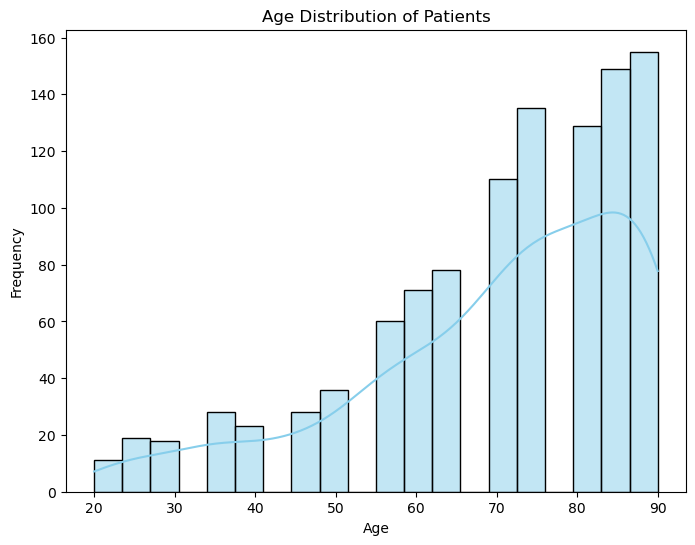

In [67]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a histogram of age distribution
plt.figure(figsize=(8, 6))
sns.histplot(df['Age'], bins=20, kde=True, color='skyblue')
plt.title('Age Distribution of Patients')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()


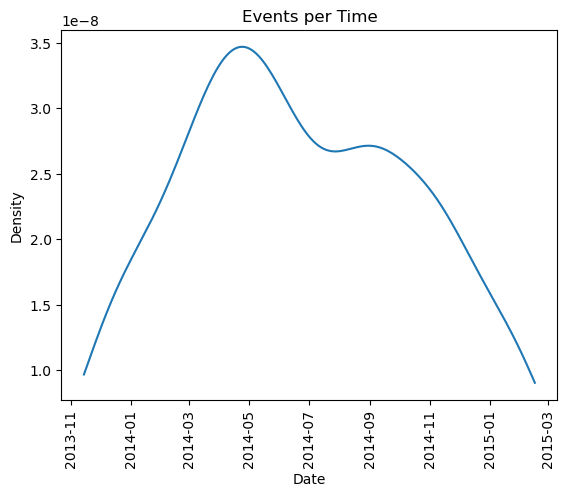

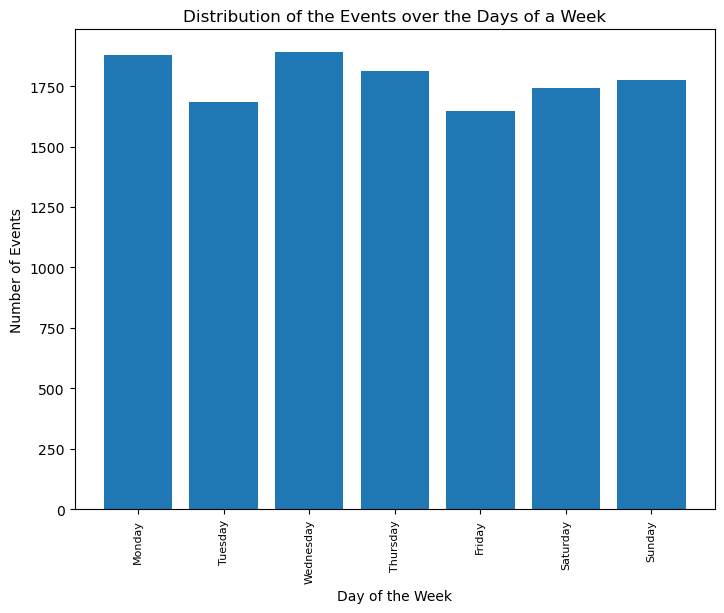

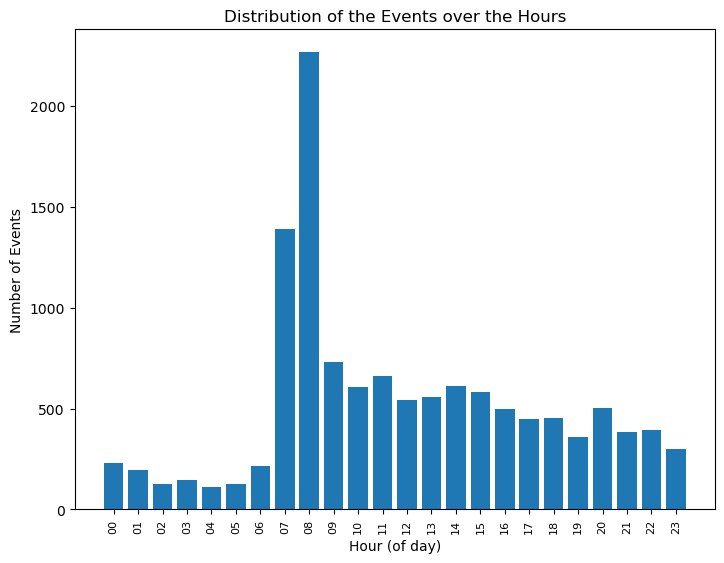

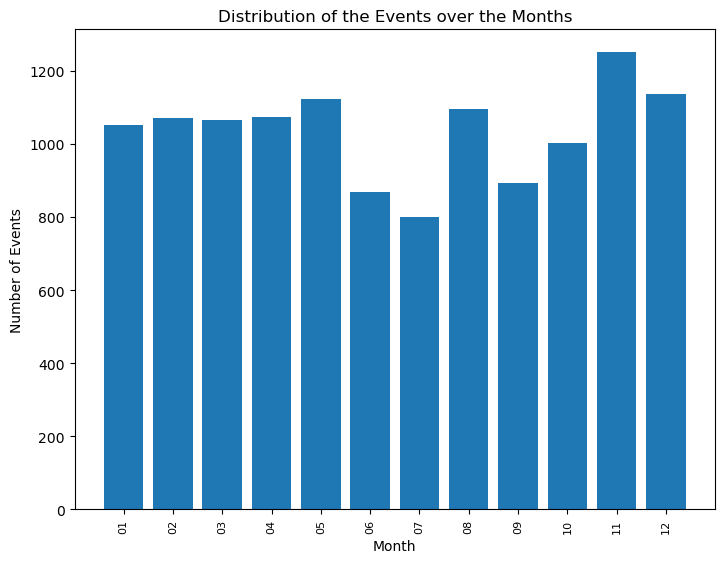

In [68]:
pm4py.view_events_per_time_graph(filtered_log)
pm4py.view_events_distribution_graph(filtered_log)
pm4py.view_events_distribution_graph(filtered_log, distr_type="hours")
pm4py.view_events_distribution_graph(filtered_log, distr_type="months")

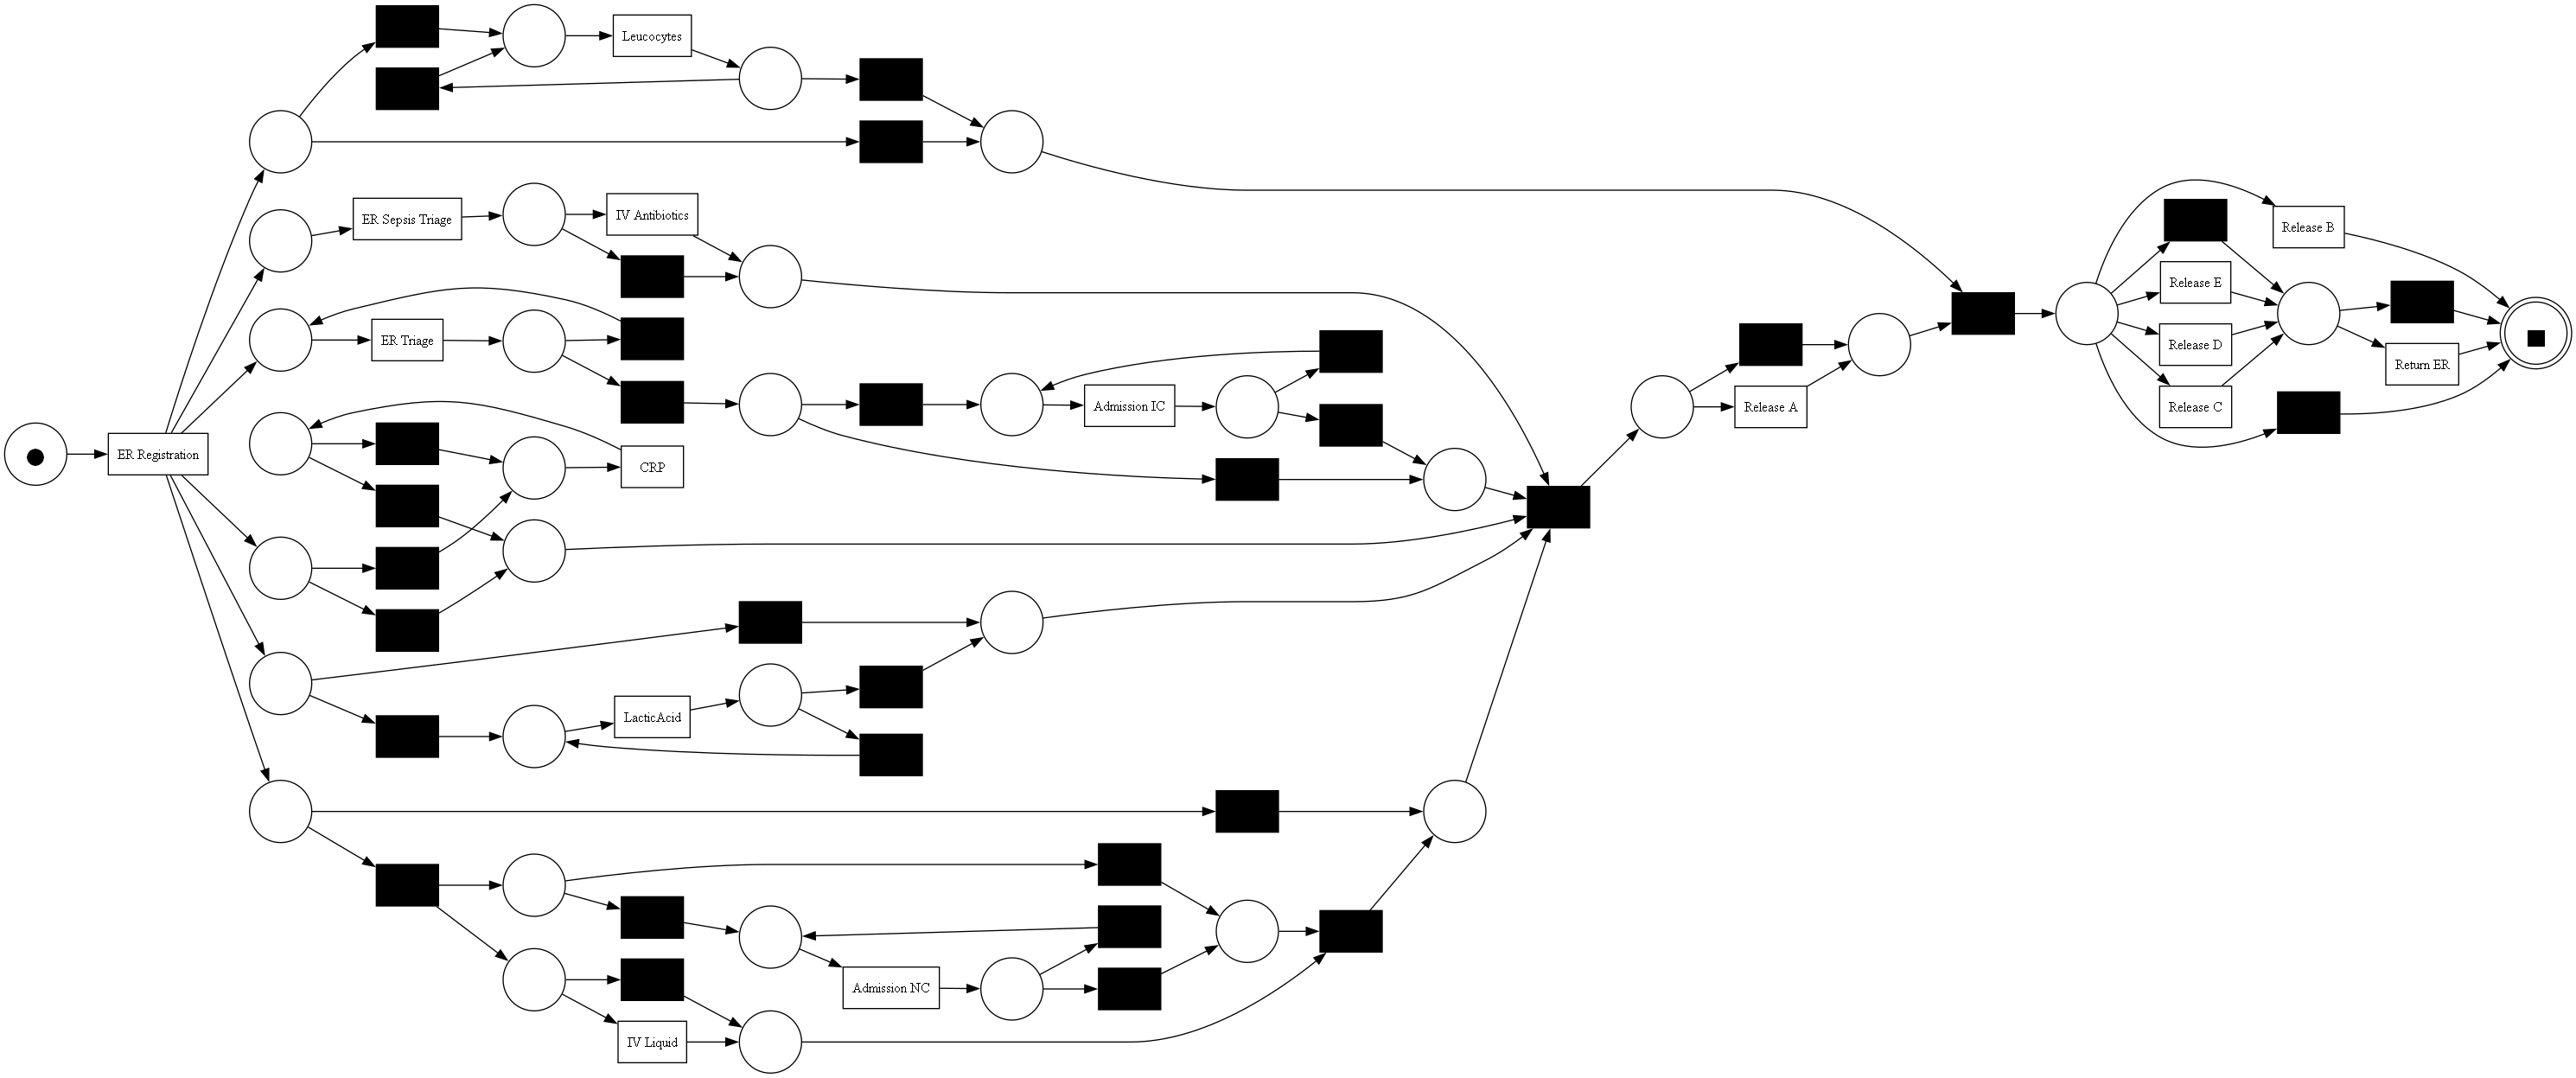

In [69]:
pn1, im, fm = pm4py.discover_petri_net_inductive(filtered_log)
pm4py.view_petri_net(pn1, im, fm)


Alpha Petri Net for 1 most common variants


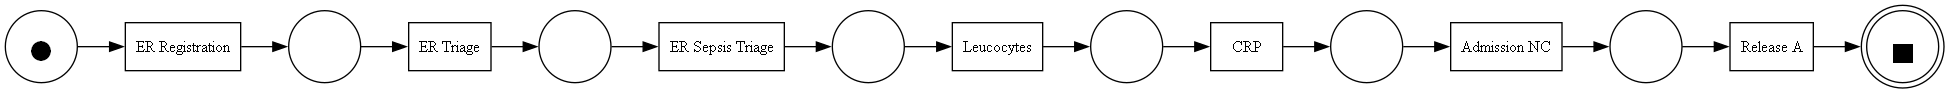

Alpha Petri Net for 2 most common variants


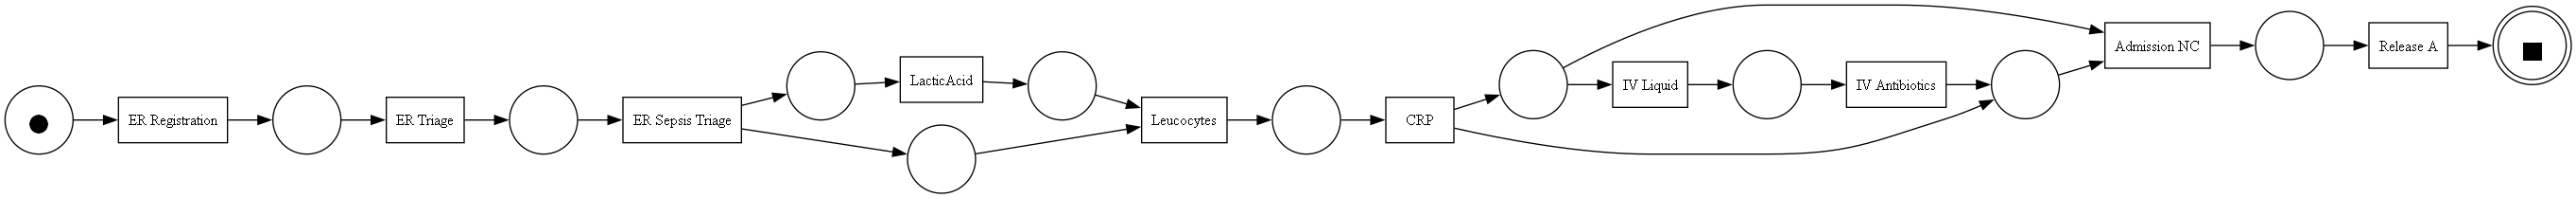

Alpha Petri Net for 3 most common variants


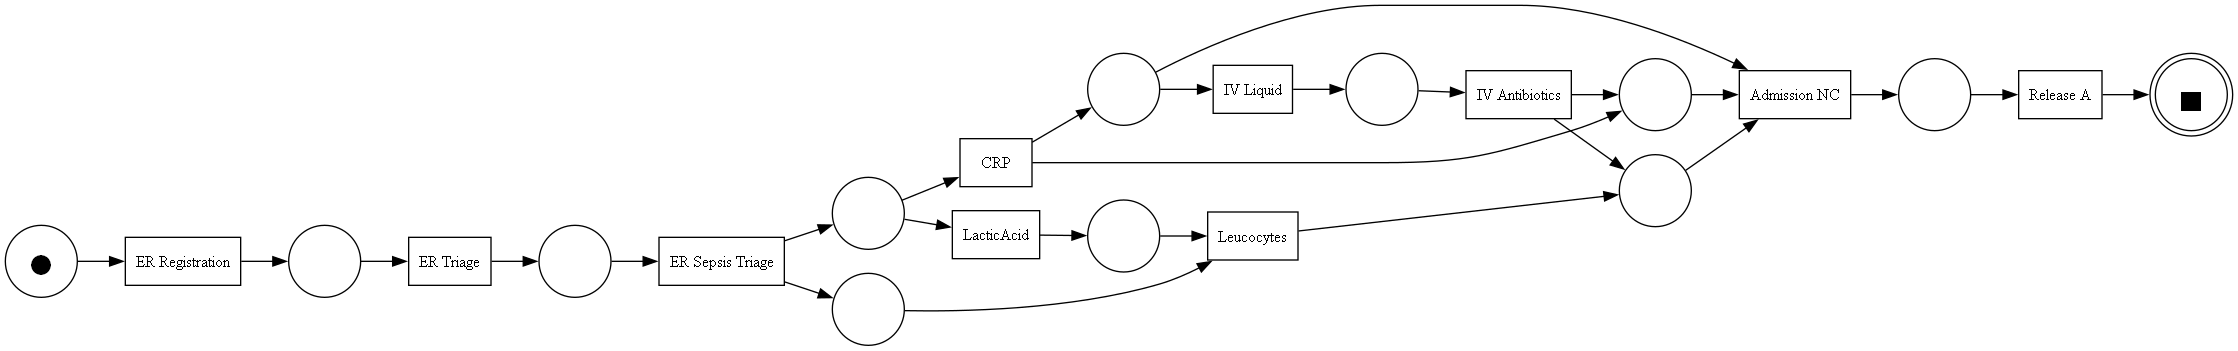

Alpha Petri Net for 4 most common variants


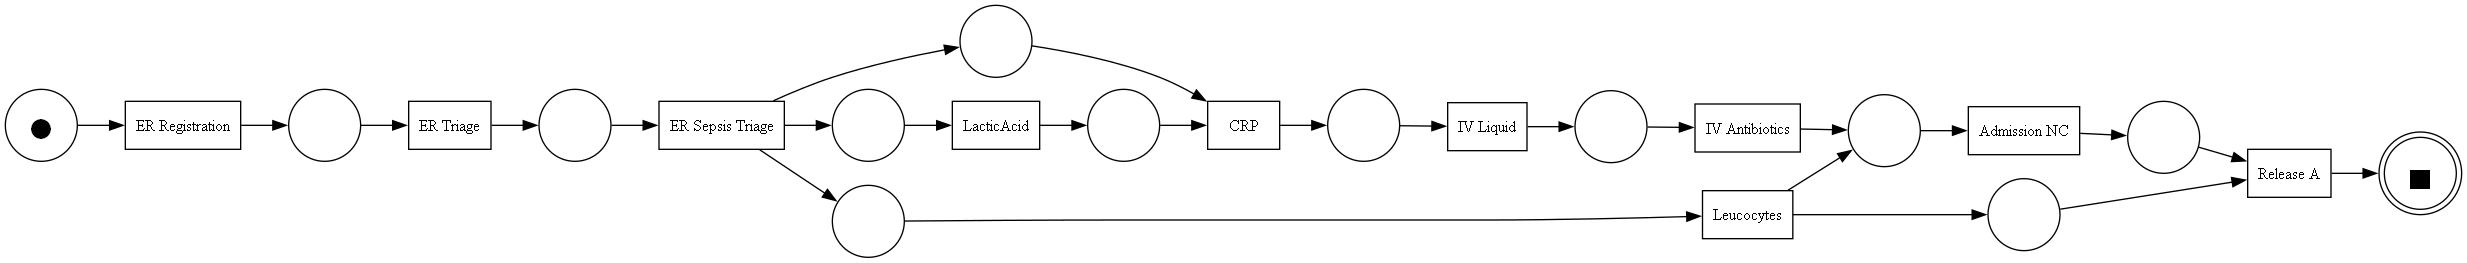

Alpha Petri Net for 10 most common variants


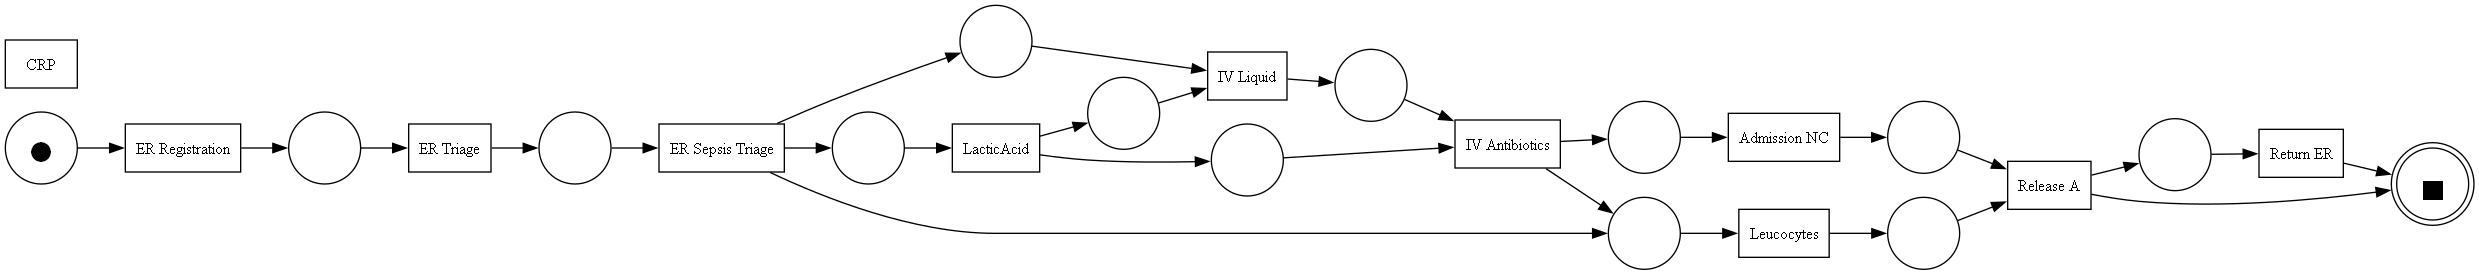

Alpha Petri Net for 20 most common variants


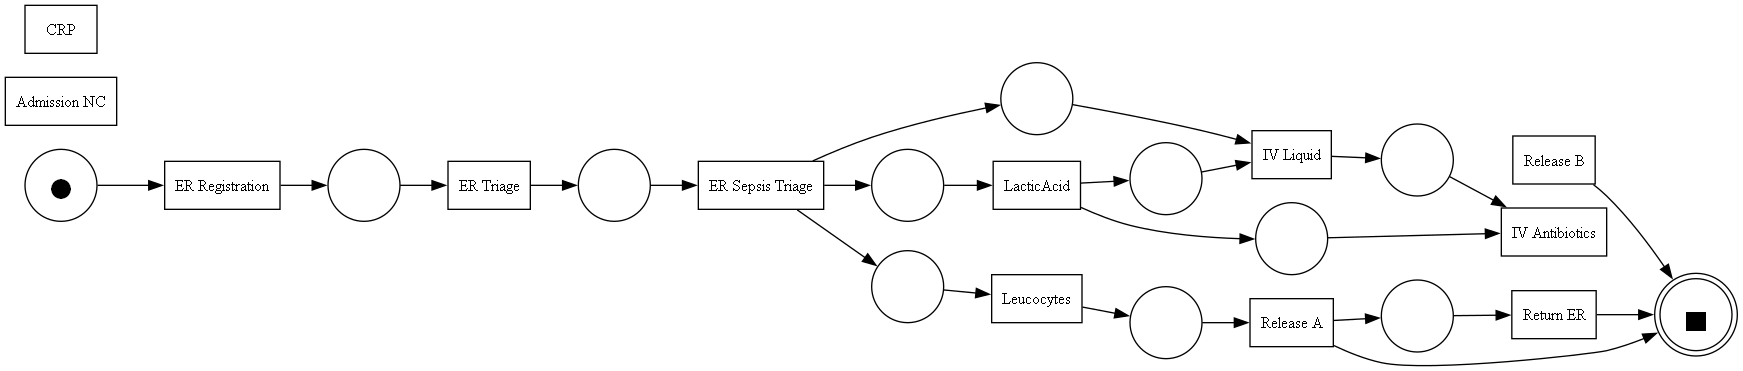

Alpha Petri Net for 25 most common variants


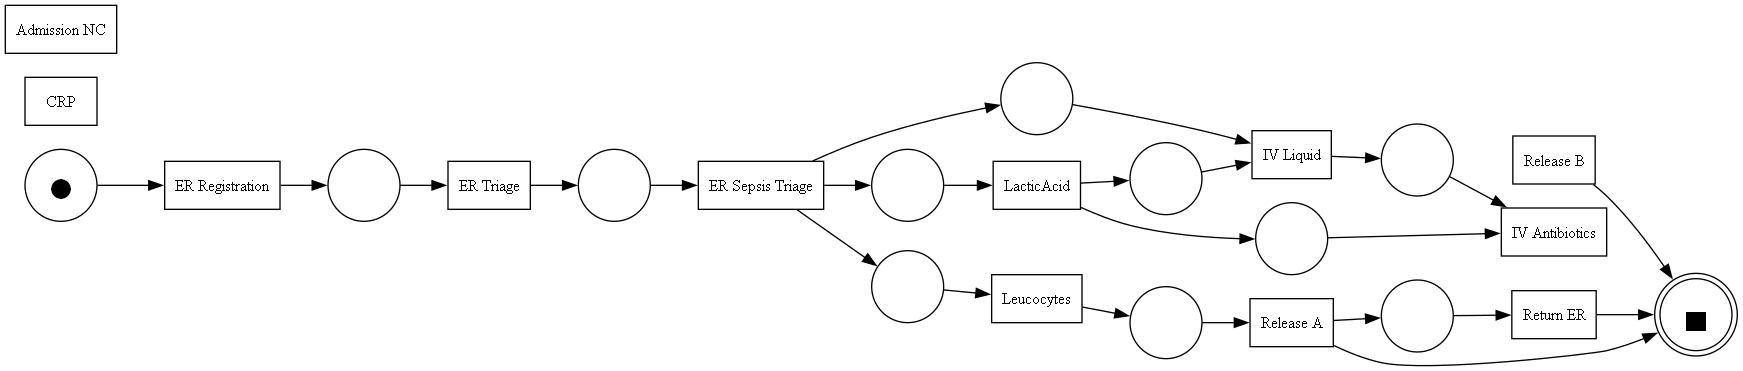

Alpha Petri Net for 30 most common variants


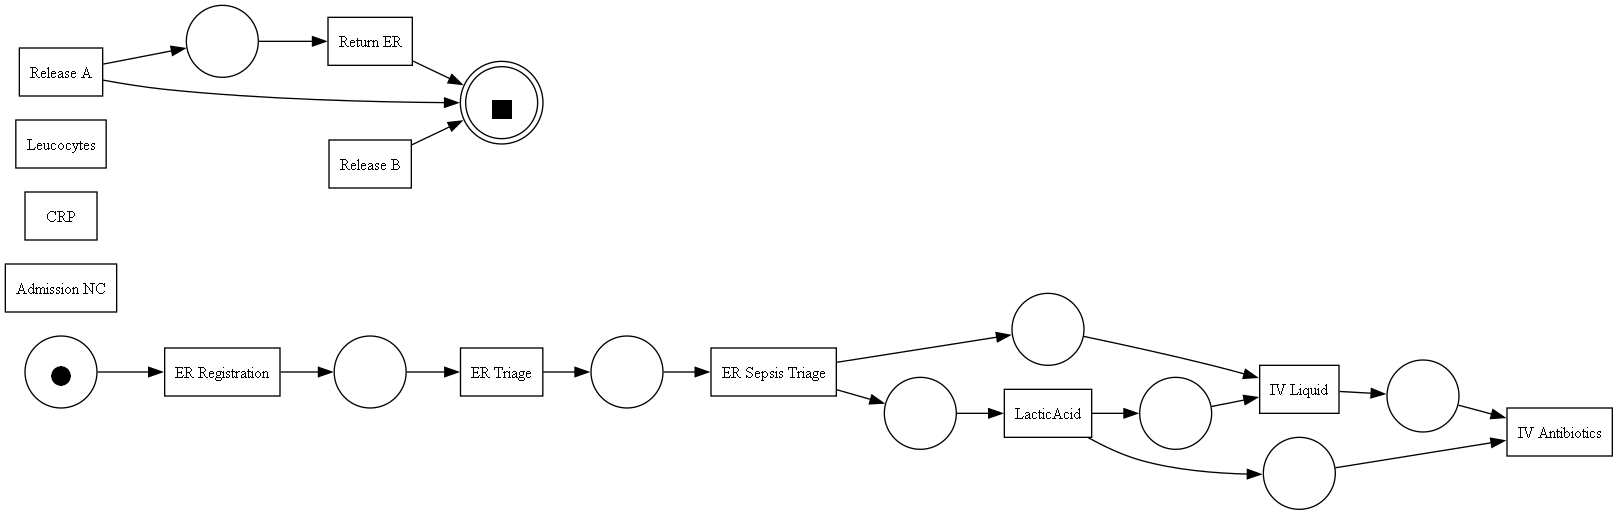

Alpha Petri Net for 35 most common variants


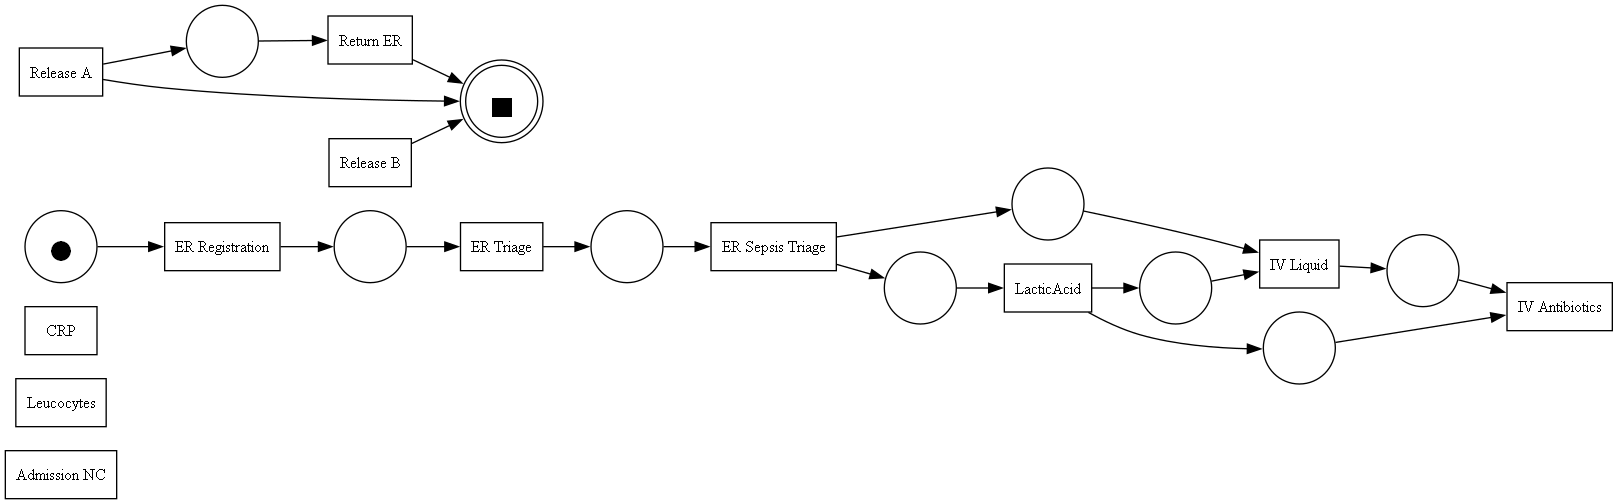

Alpha Petri Net for 685 most common variants


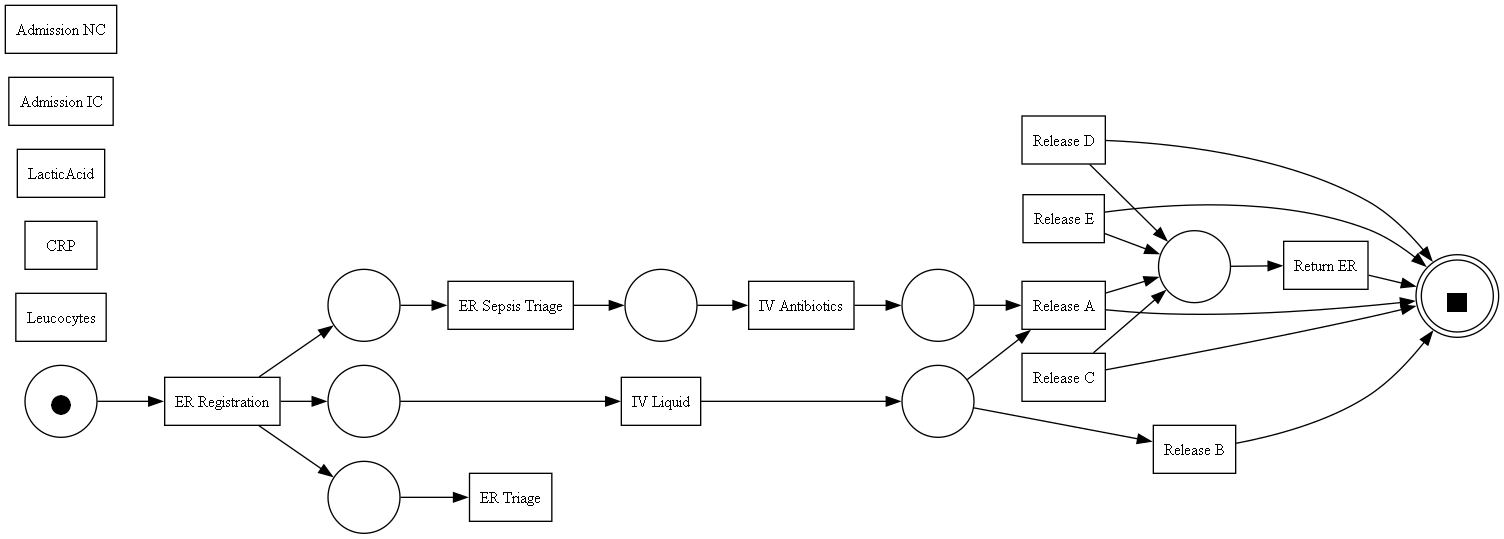

In [70]:
values_of_i = [1, 2, 3, 4, 10, 20, 25,30, 35, len(common_variants)]

for i in values_of_i:
    # Filter the log for the first i variants
    current_variants = common_variants.iloc[:i]["variant"]
    current_log = pm4py.filter_variants(filtered_log, set(current_variants))
    current_log_copy = current_log.copy()
        
    # Discover a Petri net for the most common variant
    pn_cur, im_cur, fm_cur = pm4py.discover_petri_net_alpha(current_log_copy)
    net = pm4py.discover_petri_net_alpha(current_log_copy)
    print(f"Alpha Petri Net for {i} most common variants")
    pm4py.view_petri_net(pn_cur, im_cur, fm_cur)


Inductive Petri Net for 1 most common variants


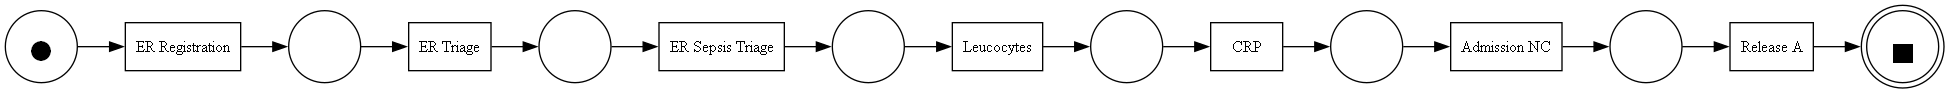

aligning log, completed variants :: 100%|██████████| 685/685 [00:06<00:00, 106.74it/s]
computing precision with alignments, completed variants :: 100%|██████████| 5115/5115 [00:14<00:00, 350.51it/s]
replaying log with TBR, completed traces :: 100%|██████████| 685/685 [00:01<00:00, 440.88it/s]


            Metric     Value
0  Average Fitness  0.586572
1        Precision  1.000000
2   Generalization  0.968781
3       Simplicity  1.000000
Inductive Petri Net for 2 most common variants


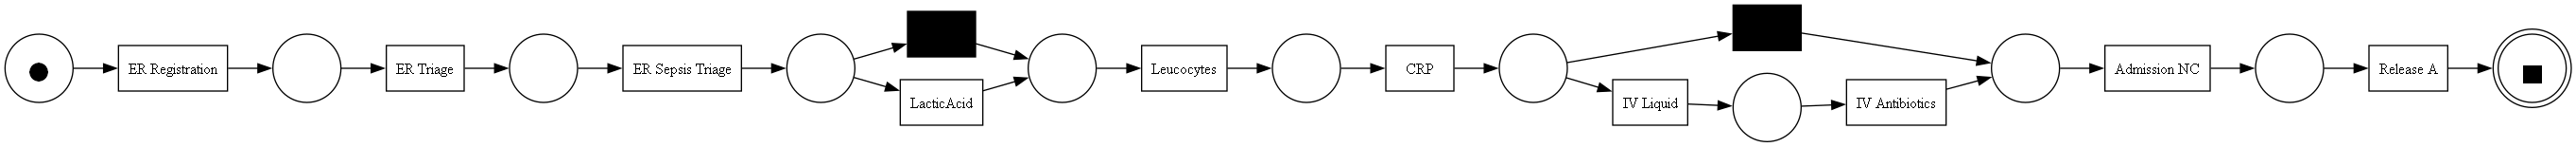

aligning log, completed variants :: 100%|██████████| 685/685 [00:11<00:00, 58.12it/s]
computing precision with alignments, completed variants :: 100%|██████████| 5115/5115 [00:25<00:00, 200.71it/s]
replaying log with TBR, completed traces :: 100%|██████████| 685/685 [00:02<00:00, 324.64it/s]


            Metric     Value
0  Average Fitness  0.638313
1        Precision  0.999123
2   Generalization  0.964027
3       Simplicity  0.920000
Inductive Petri Net for 3 most common variants


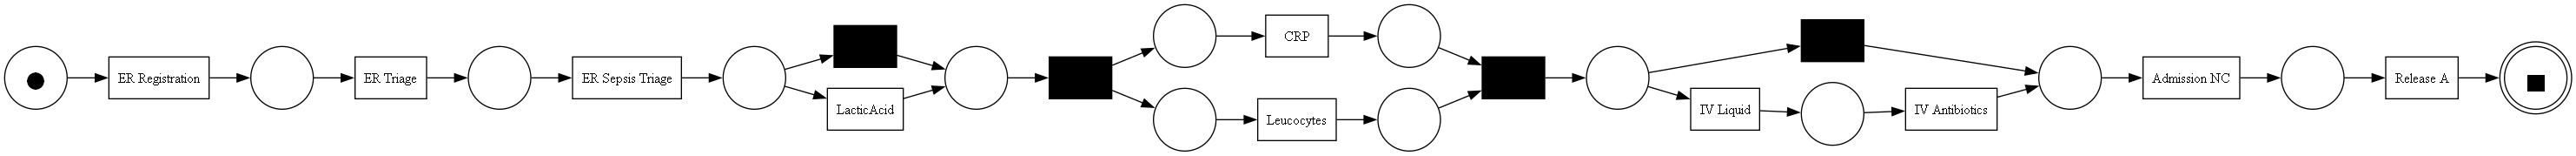

aligning log, completed variants :: 100%|██████████| 685/685 [00:12<00:00, 55.25it/s]
computing precision with alignments, completed variants :: 100%|██████████| 5115/5115 [00:25<00:00, 198.14it/s]
replaying log with TBR, completed traces :: 100%|██████████| 685/685 [00:02<00:00, 241.72it/s]


            Metric     Value
0  Average Fitness  0.662696
1        Precision  0.999010
2   Generalization  0.965044
3       Simplicity  0.875000
Inductive Petri Net for 4 most common variants


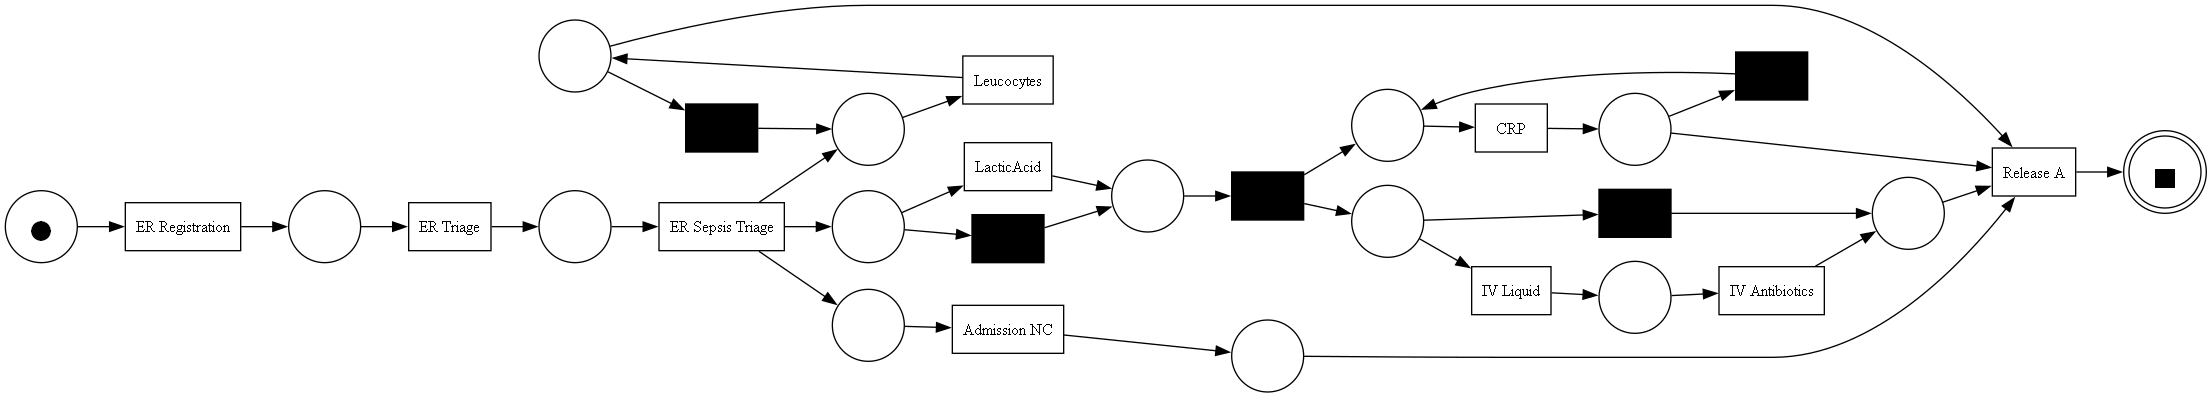

aligning log, completed variants :: 100%|██████████| 685/685 [00:18<00:00, 36.10it/s]
computing precision with alignments, completed variants :: 100%|██████████| 5115/5115 [00:30<00:00, 167.94it/s]
replaying log with TBR, completed traces :: 100%|██████████| 685/685 [00:02<00:00, 303.13it/s]


            Metric     Value
0  Average Fitness  0.871396
1        Precision  0.835683
2   Generalization  0.962168
3       Simplicity  0.714286
Inductive Petri Net for 10 most common variants


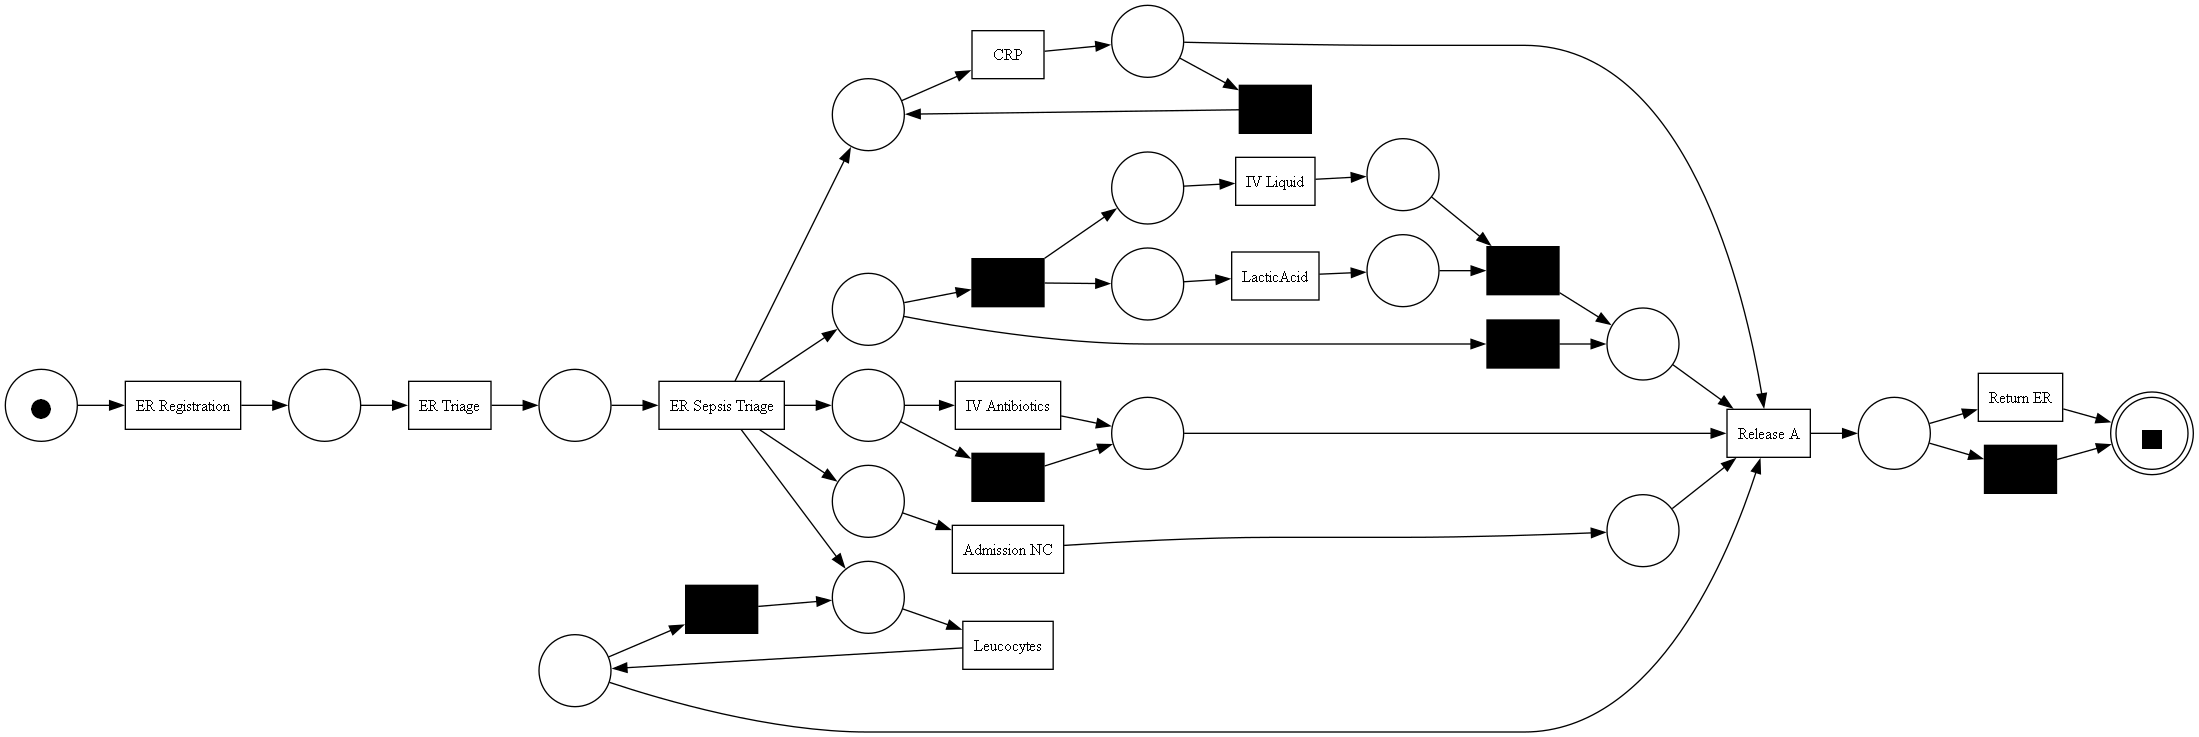

aligning log, completed variants :: 100%|██████████| 685/685 [00:13<00:00, 50.34it/s]
computing precision with alignments, completed variants :: 100%|██████████| 5115/5115 [00:55<00:00, 92.60it/s] 
replaying log with TBR, completed traces :: 100%|██████████| 685/685 [00:02<00:00, 312.19it/s]


            Metric     Value
0  Average Fitness  0.917519
1        Precision  0.757249
2   Generalization  0.955044
3       Simplicity  0.672727
Inductive Petri Net for 20 most common variants


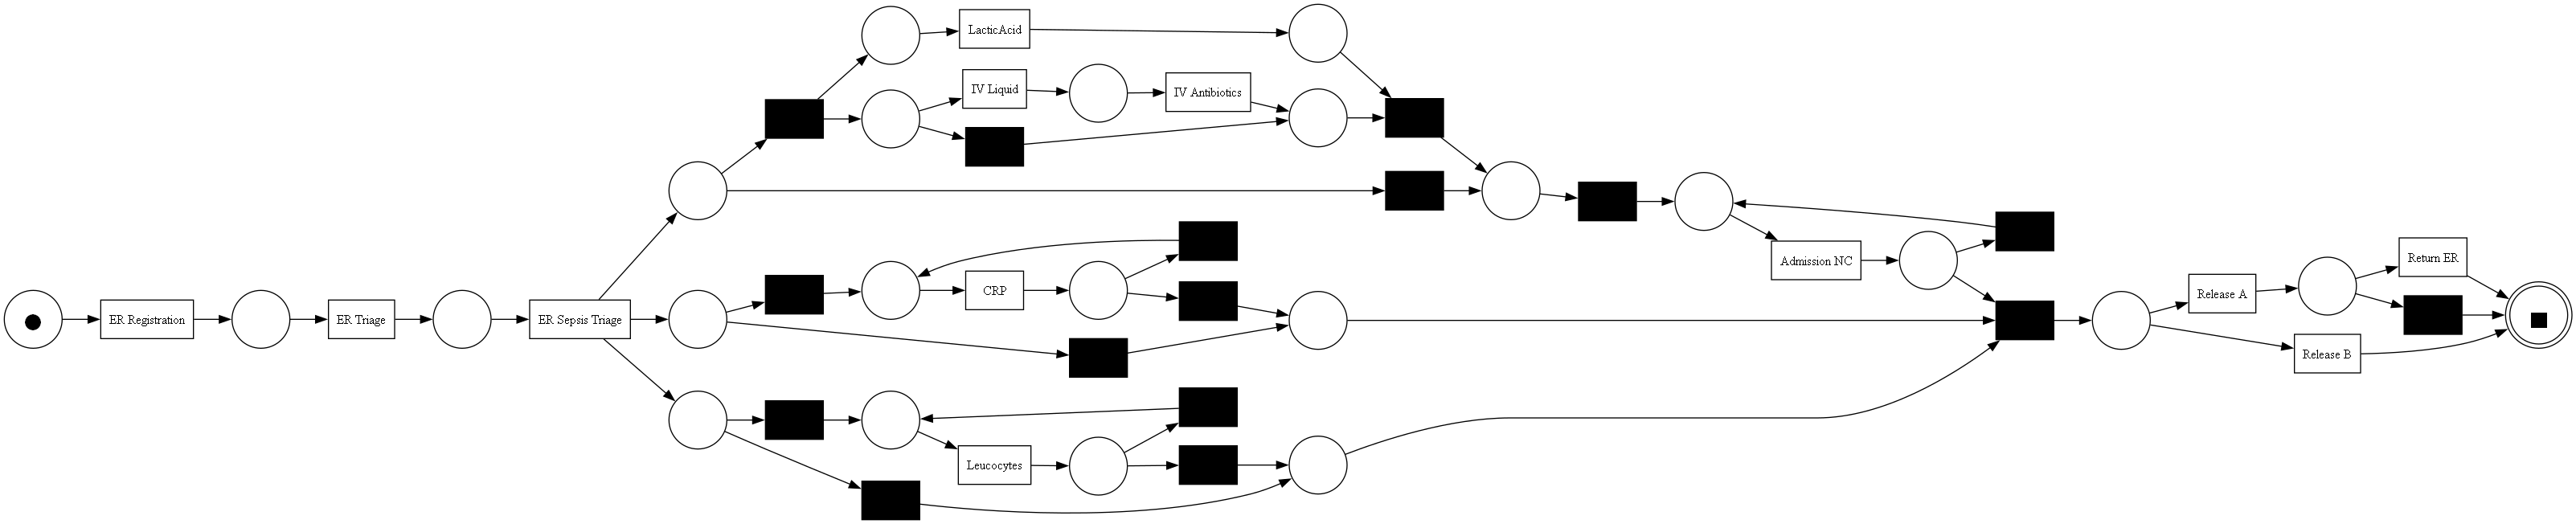

aligning log, completed variants :: 100%|██████████| 685/685 [00:54<00:00, 12.50it/s]
computing precision with alignments, completed variants :: 100%|██████████| 5115/5115 [01:39<00:00, 51.27it/s] 
replaying log with TBR, completed traces :: 100%|██████████| 685/685 [00:02<00:00, 239.12it/s]


            Metric     Value
0  Average Fitness  0.931129
1        Precision  0.776413
2   Generalization  0.943977
3       Simplicity  0.698630
Inductive Petri Net for 25 most common variants


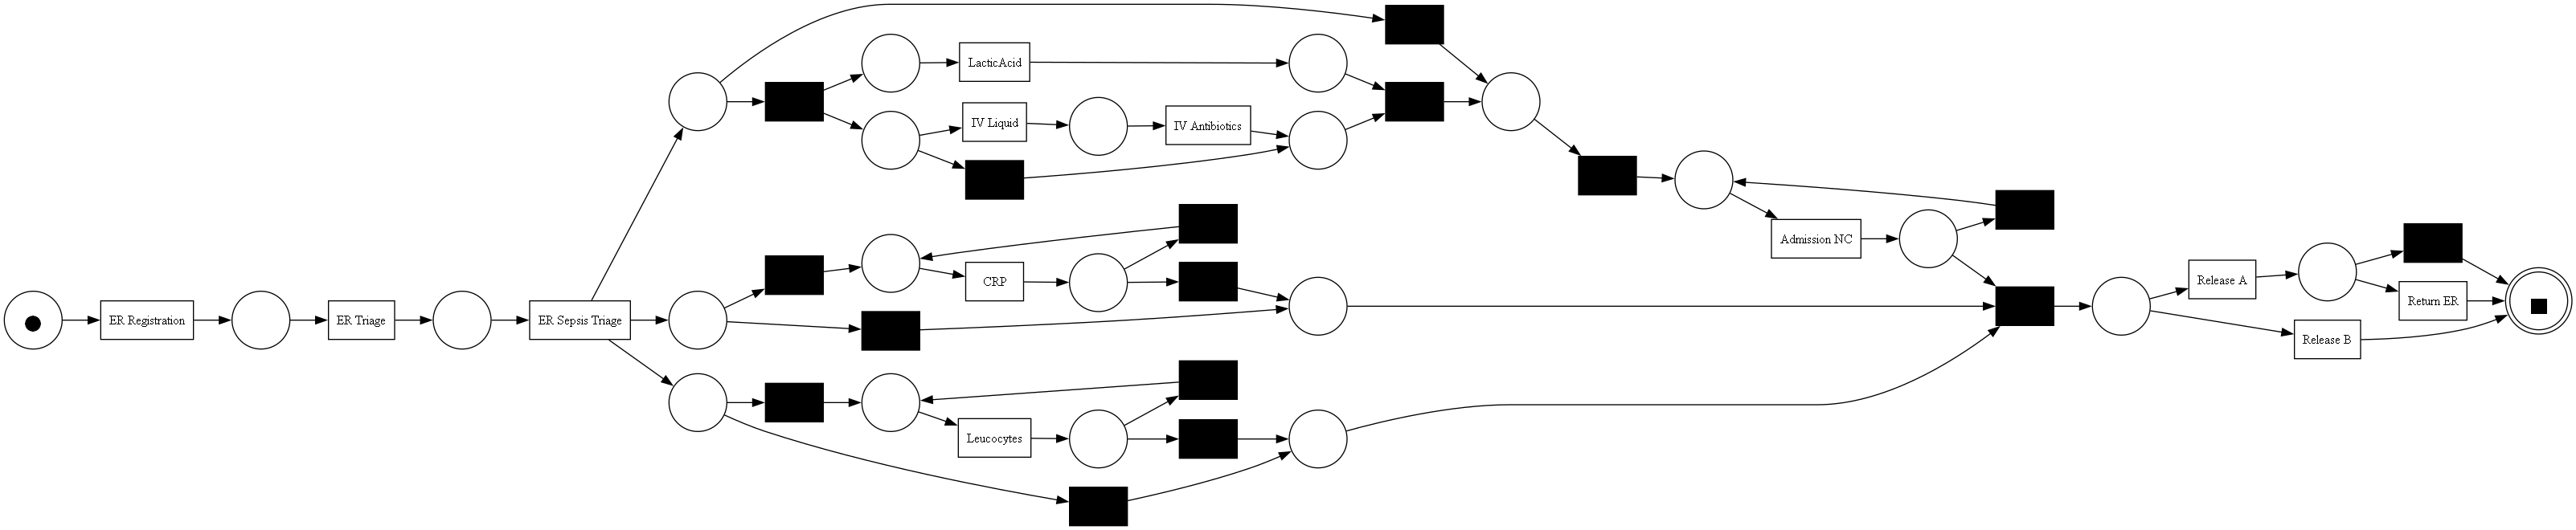

aligning log, completed variants :: 100%|██████████| 685/685 [00:51<00:00, 13.41it/s]
computing precision with alignments, completed variants :: 100%|██████████| 5115/5115 [01:41<00:00, 50.40it/s] 
replaying log with TBR, completed traces :: 100%|██████████| 685/685 [00:02<00:00, 282.18it/s]


            Metric     Value
0  Average Fitness  0.931129
1        Precision  0.776413
2   Generalization  0.943977
3       Simplicity  0.698630
Inductive Petri Net for 30 most common variants


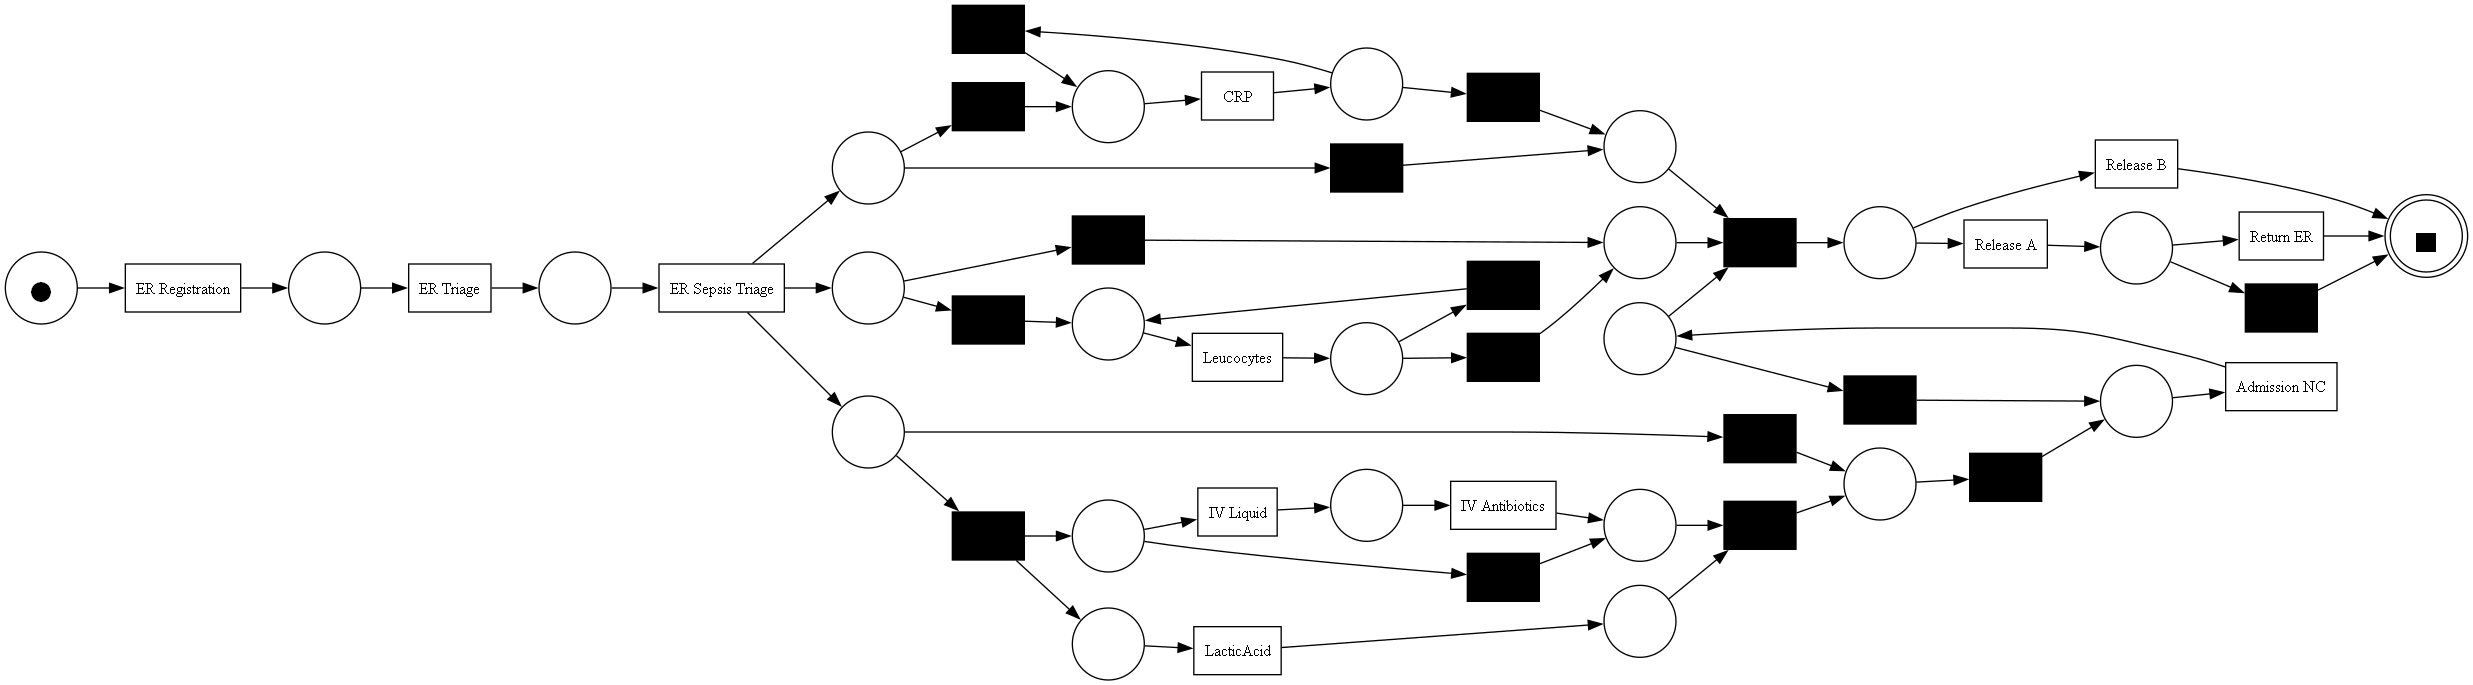

aligning log, completed variants :: 100%|██████████| 685/685 [00:58<00:00, 11.63it/s]
computing precision with alignments, completed variants :: 100%|██████████| 5115/5115 [01:49<00:00, 46.74it/s] 
replaying log with TBR, completed traces :: 100%|██████████| 685/685 [00:02<00:00, 234.84it/s]


            Metric     Value
0  Average Fitness  0.931129
1        Precision  0.776413
2   Generalization  0.943977
3       Simplicity  0.698630
Inductive Petri Net for 35 most common variants


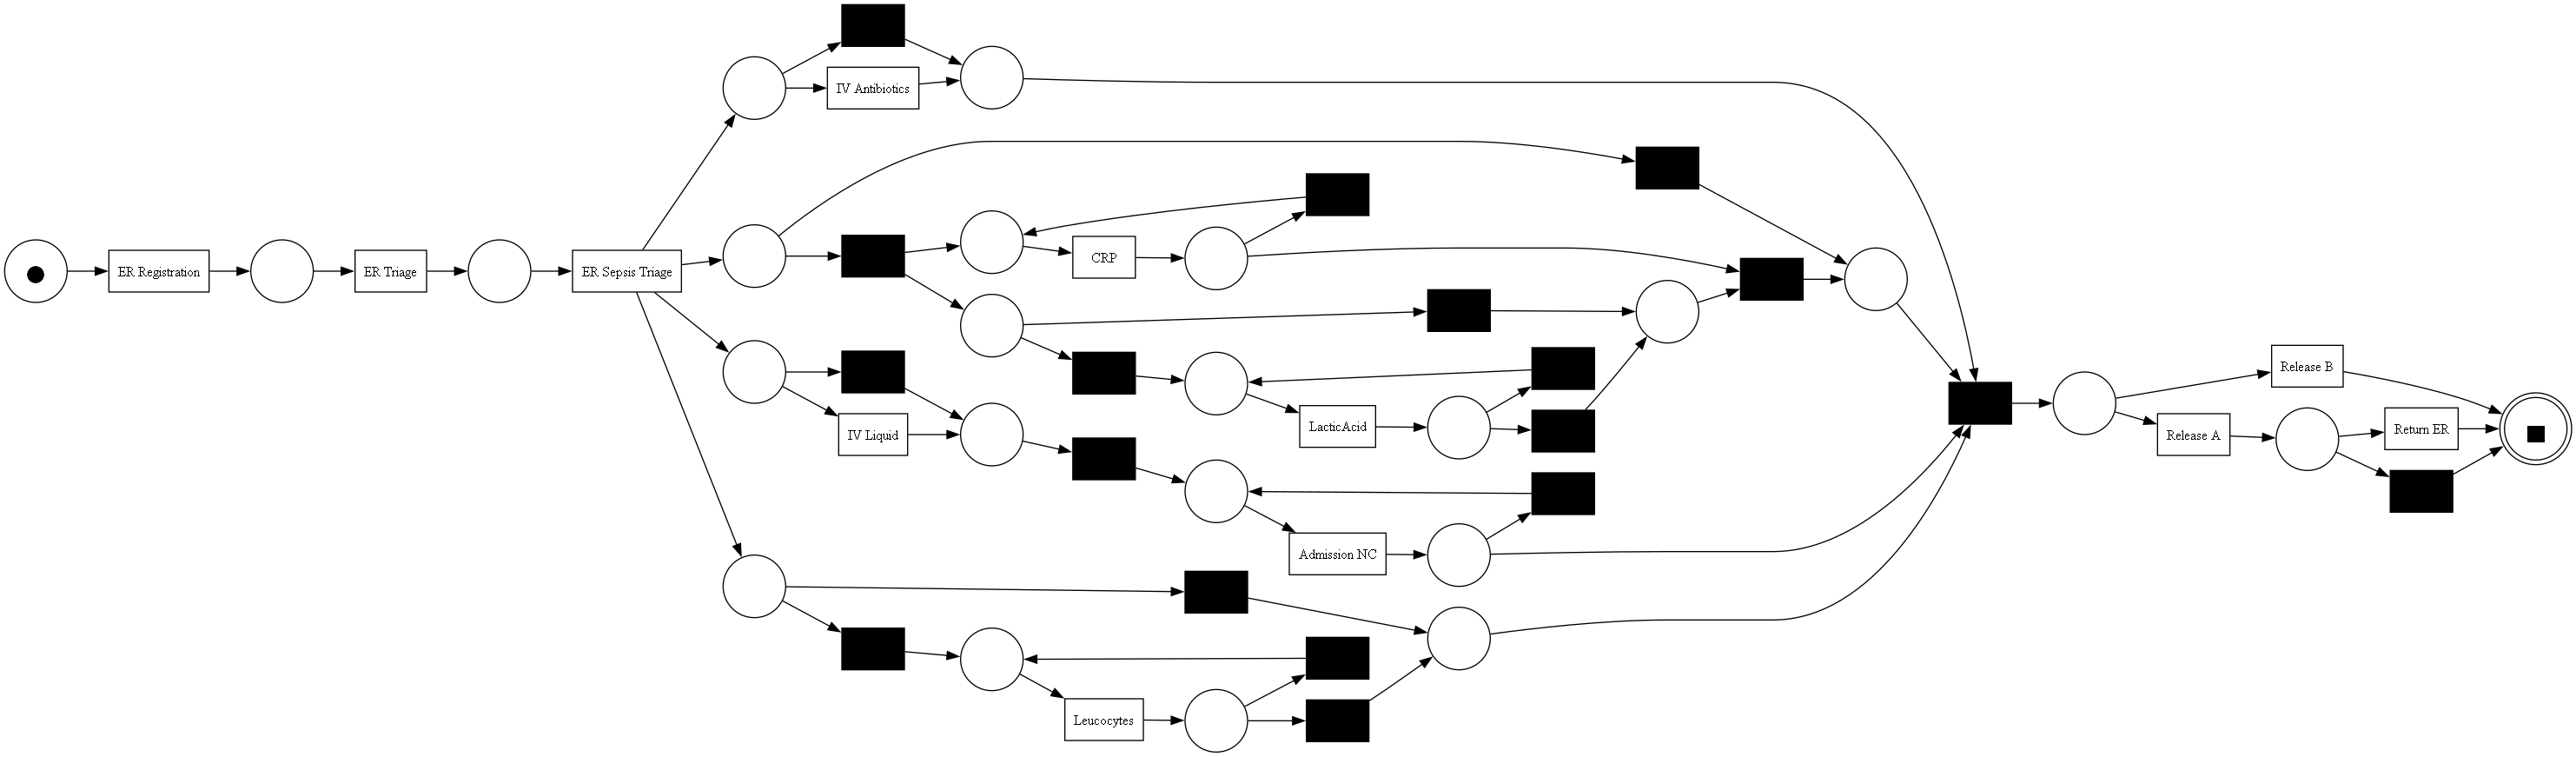

aligning log, completed variants :: 100%|██████████| 685/685 [01:18<00:00,  8.72it/s]
computing precision with alignments, completed variants :: 100%|██████████| 5115/5115 [04:12<00:00, 20.29it/s] 
replaying log with TBR, completed traces :: 100%|██████████| 685/685 [00:01<00:00, 352.44it/s]


            Metric     Value
0  Average Fitness  0.966460
1        Precision  0.648889
2   Generalization  0.946067
3       Simplicity  0.658537
Inductive Petri Net for 685 most common variants


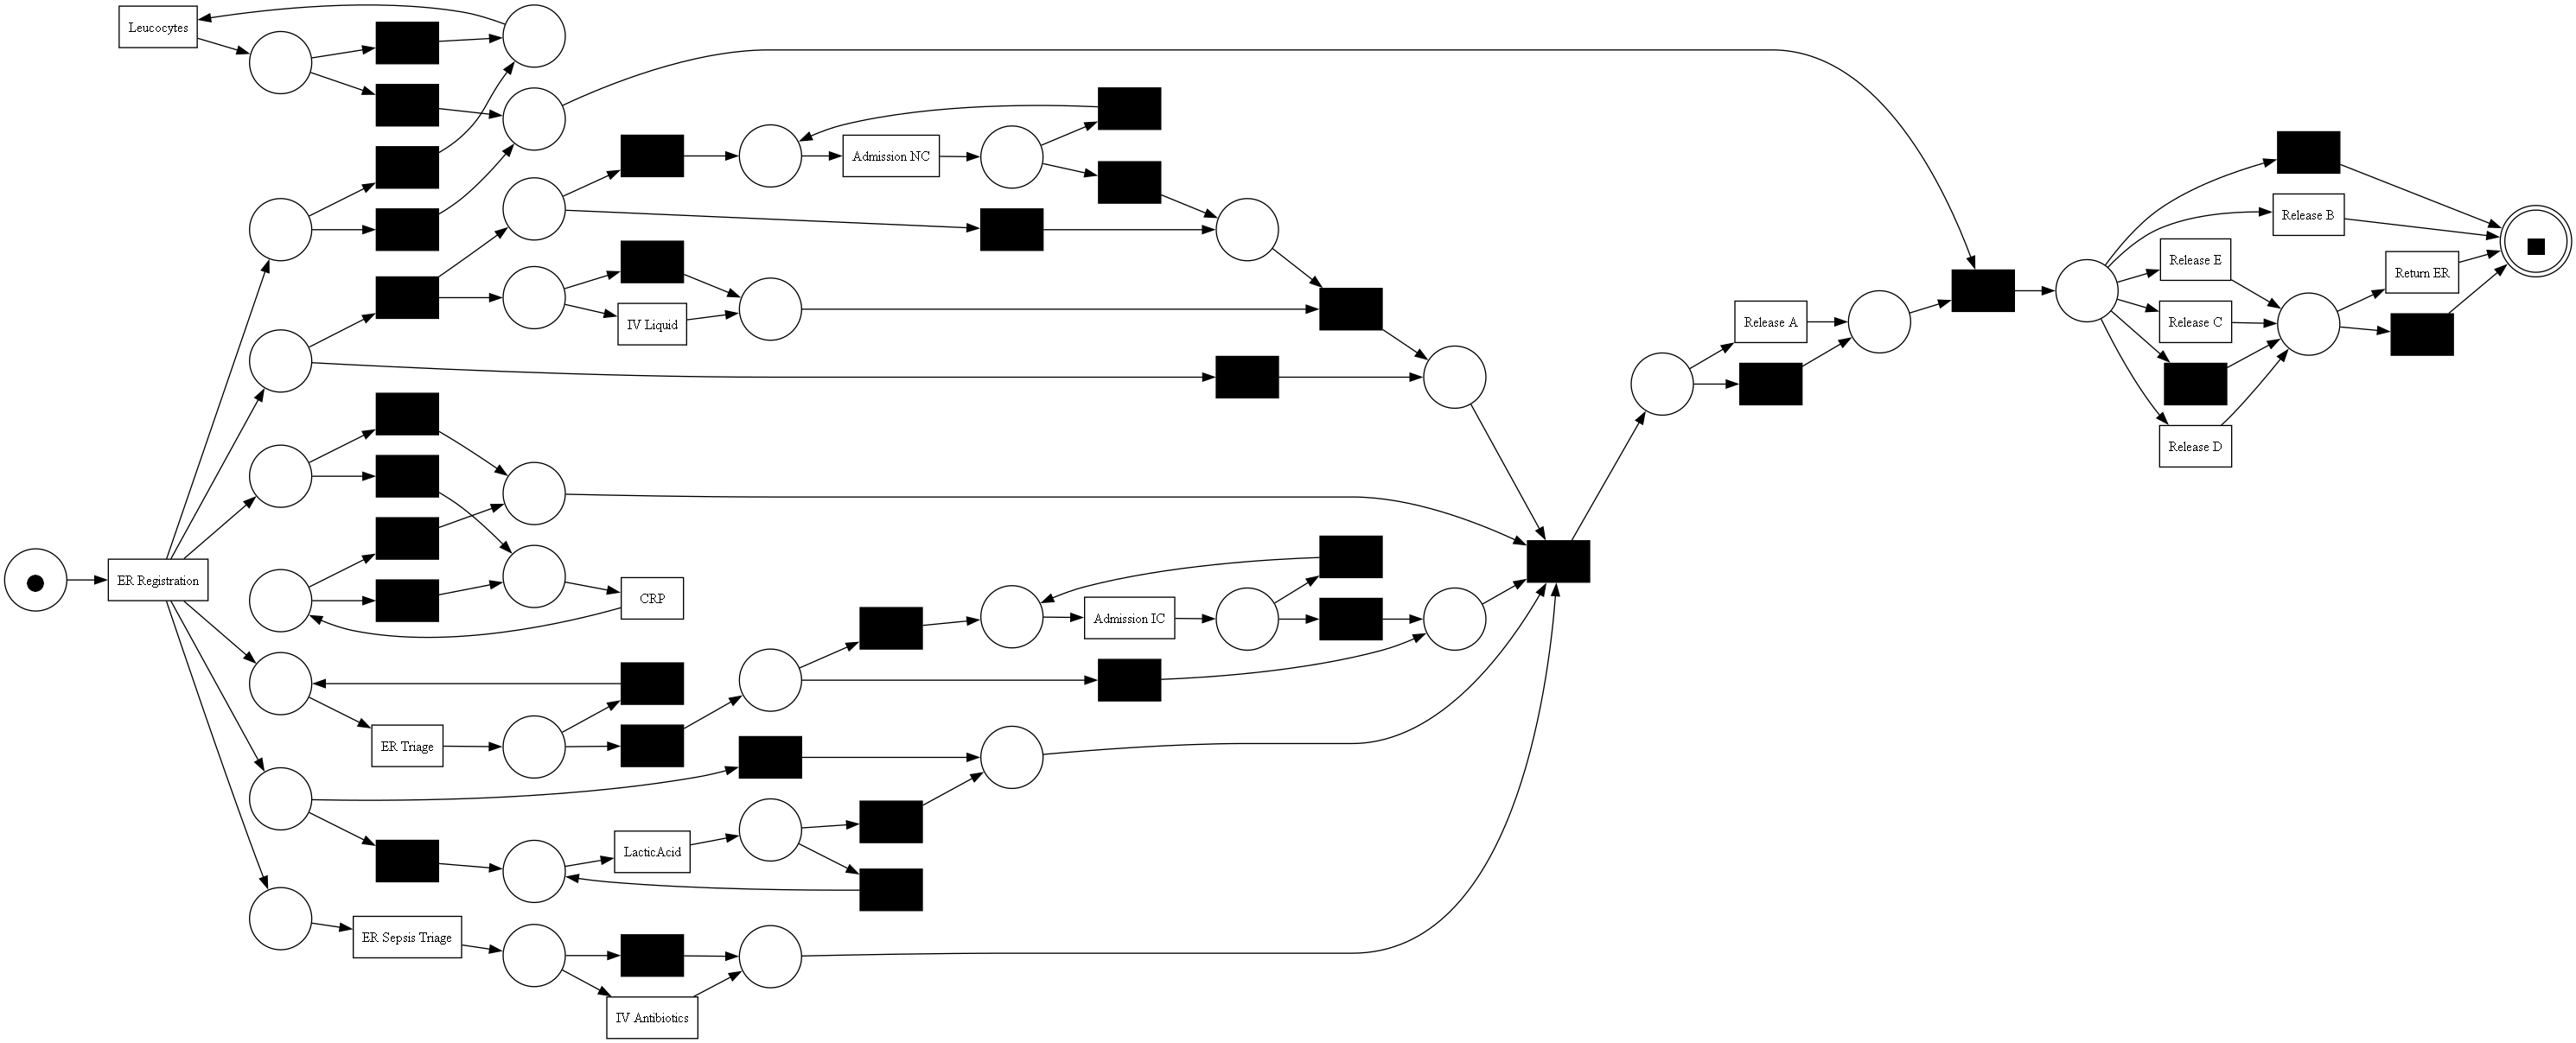

aligning log, completed variants :: 100%|██████████| 685/685 [11:54<00:00,  1.04s/it]
computing precision with alignments, completed variants :: 100%|██████████| 5115/5115 [3:34:12<00:00,  2.51s/it]  
replaying log with TBR, completed traces :: 100%|██████████| 685/685 [00:02<00:00, 240.28it/s]

            Metric     Value
0  Average Fitness  1.000000
1        Precision  0.301883
2   Generalization  0.865130
3       Simplicity  0.617647


In [71]:
for i in values_of_i:
    # Filter the log for the first i variants
    current_variants = common_variants.iloc[:i]["variant"]
    current_log = pm4py.filter_variants(filtered_log, set(current_variants))
        
    # Discover a Petri net for the most common variant
    pn_cur, im_cur, fm_cur = pm4py.discover_petri_net_inductive(current_log)
    net= pm4py.discover_petri_net_inductive(current_log)
    print(f"Inductive Petri Net for {i} most common variants")
    pm4py.view_petri_net(pn_cur, im_cur, fm_cur)
    aligments(filtered_log,net)



In [72]:
def aligments(log, net):
    fitness = pm4py.fitness_alignments(log, *net)
    precision = pm4py.precision_alignments(log, *net)
    generalization = generalization_evaluator.apply(log, *net)
    simplicity = simplicity_evaluator.apply(net[0])


    # Create a DataFrame
    df = pd.DataFrame({
        "Metric": ["Average Fitness", "Precision", "Generalization", "Simplicity"],
        "Value": [fitness["averageFitness"], precision, generalization, simplicity]
    })

    # Print the DataFrame
    print(df)

In [73]:
woflan_parameters = {
    woflan.Parameters.RETURN_ASAP_WHEN_NOT_SOUND: False,
    woflan.Parameters.PRINT_DIAGNOSTICS: True,
    woflan.Parameters.RETURN_DIAGNOSTICS: False
}
current_variants = common_variants.iloc[:3]["variant"]
current_log = pm4py.filter_variants(filtered_log, set(current_variants))
current_log_copy = current_log.copy()


wfnet_alpha = pm4py.discover_petri_net_inductive(current_log_copy)
is_sound = woflan.apply(*wfnet_alpha, parameters=woflan_parameters)
print(f"Is sound: {is_sound}")

c:\Users\Lenovo\anaconda3\envs\dm\lib\site-packages\pm4py\algo\analysis\woflan\place_invariants\utility.py:153: UserWarning: solution from scipy may be unstable. Please install PuLP (pip install pulp) for fully reliable results.
  warnings.warn("solution from scipy may be unstable. Please install PuLP (pip install pulp) for fully reliable results.")


Input is ok.
Petri Net is a workflow net.
Every place is covered by s-components.
There are no dead tasks.
All tasks are live.
Is sound: True


## for Asaf
### note the the best model is three .
### please added section for the question 2a and 2b.

Inductive Petri Net for 3 most common variants


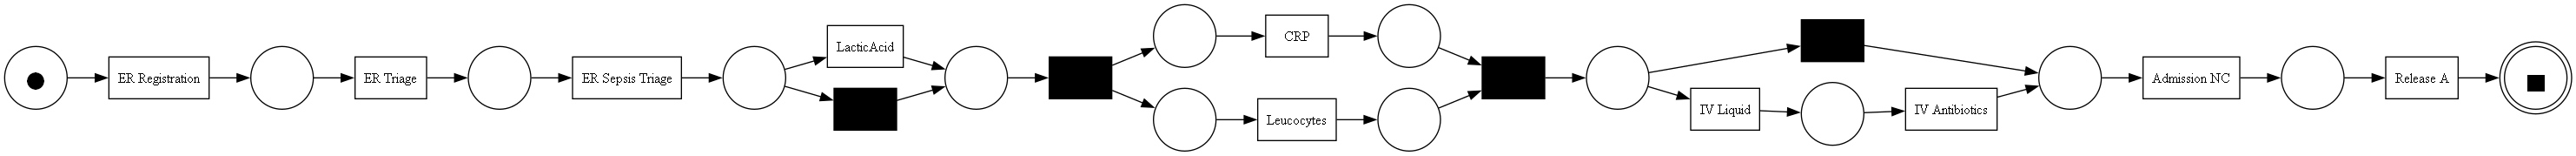

aligning log, completed variants :: 100%|██████████| 685/685 [00:09<00:00, 75.71it/s]
computing precision with alignments, completed variants :: 100%|██████████| 5115/5115 [00:22<00:00, 225.04it/s]
replaying log with TBR, completed traces :: 100%|██████████| 685/685 [00:01<00:00, 354.11it/s]

            Metric     Value
0  Average Fitness  0.662696
1        Precision  0.999010
2   Generalization  0.965044
3       Simplicity  0.875000


In [74]:
values_of_i = [3]
for i in values_of_i:
    # Filter the log for the first i variants
    current_variants = common_variants.iloc[:i]["variant"]
    current_log = pm4py.filter_variants(filtered_log, set(current_variants))
    dataframe = pm4py.convert_to_dataframe(current_log)
    dataframe.to_csv('Sepsis_Cases_3_Most_Common.csv')
        
    # Discover a Petri net for the most common variant
    pn_cur, im_cur, fm_cur = pm4py.discover_petri_net_inductive(current_log)
    net= pm4py.discover_petri_net_inductive(current_log)
    print(f"Inductive Petri Net for {i} most common variants")
    pm4py.view_petri_net(pn_cur, im_cur, fm_cur)
    aligments(filtered_log,net)